In [1]:
from torch.nn import Module, Sequential, Linear, LeakyReLU, Sigmoid, BCELoss
from torch.utils.data import DataLoader, TensorDataset
from torch import device, cuda
from torch.optim import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm
import torch
from time import time
import os

import sys
sys.path.append('..')  
from src.utils.RawDataReader import RawDataReader



In [2]:
reader = RawDataReader()
labels = reader.get_labels()
datasets, means, stds = reader.get_normalised_dataset()

In [3]:
class SingleHeadModel(Module):
    def __init__(self, feature_count:int, hidden_count:int=5):
        super(SingleHeadModel, self).__init__()

        self.slope = 0.001

        self.model = Sequential(
            *[self.linear_block(feature_count,feature_count) for _ in range(hidden_count)],
            Linear(in_features=feature_count, out_features=1),
            Sigmoid()
        )

    def linear_block(self, in_features, out_features):
        return Sequential(
            Linear(in_features=in_features, out_features=out_features),
            LeakyReLU(negative_slope=self.slope)
        )
    
    def forward(self, x):
        return self.model(x)


In [4]:
f1_scores = {}
f1_score_validations = {}
models = {}
num_labels = labels.shape[1]

validation_split = 0.05
test_split = 0.20
batch_size = 2048
learning_rate = 0.001
epochs = 99
hidden_layers = 10

num_folds = 10

random_state = 1

device = device("cuda" if cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [5]:
stratified_folds = StratifiedKFold(n_splits=num_folds, random_state=random_state, shuffle=True)

In [6]:
# curr_time = time()
# os.mkdir(f"../models/{curr_time}")

curr_time = "1701450149.9963827"

for r in reader.rs[5-1:]:
    curr_dataset = datasets[r]
    feature_count = curr_dataset.shape[1]
    for label_index in range(num_labels):
        curr_label = labels[:,[label_index]]
        x, x_validation, y, y_validation = train_test_split(curr_dataset, curr_label, test_size=validation_split, random_state=random_state, stratify=curr_label)
        x_validation = x_validation.to(device)
        y_validation = y_validation.to(device)

        for fold_index, (fold_train_index, fold_test_index) in enumerate(stratified_folds.split(x,y)):
            x_train = x[fold_train_index].to(device)
            y_train = y[fold_train_index].to(device)
            x_test = x[fold_test_index].to(device)
            y_test = y[fold_test_index].to(device)

            train_dataset = TensorDataset(x_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            test_dataset = TensorDataset(x_test, y_test)

            model = SingleHeadModel(
                feature_count=feature_count,
                hidden_count=hidden_layers
            ).to(device)

            criterion = BCELoss()
            optimizer = Adam(model.parameters(), lr=learning_rate)

            for epoch in tqdm(range(epochs), ascii=False, desc="Epoch"):
                model.train()
                total_loss = 0
                for batch_features, batch_labels in train_loader:
                    optimizer.zero_grad()
                    predictions = model(batch_features)
                    loss = criterion(predictions, batch_labels)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss
                total_loss = total_loss / len(train_loader)

                model.eval()
                predictions = model(x_test)
                
                f1 = f1_score(y_test.cpu().detach(), (predictions.cpu().detach()>0.5).float(),average='micro')
                f1_scores[(r,label_index,fold_index,epoch)] = f1
            

            val_predictions = model(x_validation)
            f1_score_validation = f1_score(y_validation.cpu().detach(), (val_predictions.cpu().detach()>0.5).float(),average='micro')
            f1_score_validations[(r,label_index,fold_index)] = f1_score_validation
            print(f"R:{r}, label:{label_index}, fold:{fold_index} --> f1:{f1_score_validation}")

            # models[(r,label_index,fold_index)] = model
            torch.save(model.state_dict(), f'../models/{curr_time}/SingleHeadModel_norm_{hidden_layers}hidden_r{r}_label{label_index}_fold{fold_index}.pth')
            model.to('cpu')
            x_train.to('cpu')
            y_train.to('cpu')
            x_test.to('cpu')
            y_test.to('cpu')

            del model
            del optimizer
            del criterion
            del train_dataset
            del train_loader
            del test_dataset
            del x_train
            del y_train
            del x_test
            del y_test

        x_validation.to('cpu')
        y_validation.to('cpu')
        del x_validation
        del y_validation


            


Epoch: 100%|██████████| 99/99 [00:26<00:00,  3.80it/s]


R:5, label:0, fold:0 --> f1:0.9264


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.82it/s]


R:5, label:0, fold:1 --> f1:0.928


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s]


R:5, label:0, fold:2 --> f1:0.9312


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.66it/s]


R:5, label:0, fold:3 --> f1:0.928


Epoch: 100%|██████████| 99/99 [00:24<00:00,  3.99it/s]


R:5, label:0, fold:4 --> f1:0.9264


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


R:5, label:0, fold:5 --> f1:0.9256


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.18it/s]


R:5, label:0, fold:6 --> f1:0.9184


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.17it/s]


R:5, label:0, fold:7 --> f1:0.936


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.14it/s]


R:5, label:0, fold:8 --> f1:0.9271999999999999


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s]


R:5, label:0, fold:9 --> f1:0.8656


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.87it/s]


R:5, label:1, fold:0 --> f1:0.9848


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s]


R:5, label:1, fold:1 --> f1:0.9832


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.25it/s]


R:5, label:1, fold:2 --> f1:0.9808


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.17it/s]


R:5, label:1, fold:3 --> f1:0.9816


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s]


R:5, label:1, fold:4 --> f1:0.9816


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.04it/s]


R:5, label:1, fold:5 --> f1:0.9792


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:1, fold:6 --> f1:0.9816


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.28it/s]


R:5, label:1, fold:7 --> f1:0.9824


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.13it/s]


R:5, label:1, fold:8 --> f1:0.0216


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s]


R:5, label:1, fold:9 --> f1:0.9776


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


R:5, label:2, fold:0 --> f1:0.8752


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s]


R:5, label:2, fold:1 --> f1:0.888


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s]


R:5, label:2, fold:2 --> f1:0.8776


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.01it/s]


R:5, label:2, fold:3 --> f1:0.88


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.95it/s]


R:5, label:2, fold:4 --> f1:0.88


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.96it/s]


R:5, label:2, fold:5 --> f1:0.8808


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.21it/s]


R:5, label:2, fold:6 --> f1:0.8704


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.17it/s]


R:5, label:2, fold:7 --> f1:0.8632


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s]


R:5, label:2, fold:8 --> f1:0.8784


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s]


R:5, label:2, fold:9 --> f1:0.864


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.88it/s]


R:5, label:3, fold:0 --> f1:0.9624


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.17it/s]


R:5, label:3, fold:1 --> f1:0.9656


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.15it/s]


R:5, label:3, fold:2 --> f1:0.9608


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.05it/s]


R:5, label:3, fold:3 --> f1:0.9616


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.94it/s]


R:5, label:3, fold:4 --> f1:0.9656


Epoch: 100%|██████████| 99/99 [00:24<00:00,  3.99it/s]


R:5, label:3, fold:5 --> f1:0.9672


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.19it/s]


R:5, label:3, fold:6 --> f1:0.9648


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.20it/s]


R:5, label:3, fold:7 --> f1:0.9696


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s]


R:5, label:3, fold:8 --> f1:0.9688


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.58it/s]


R:5, label:3, fold:9 --> f1:0.9616


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.88it/s]


R:5, label:4, fold:0 --> f1:0.8936


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.22it/s]


R:5, label:4, fold:1 --> f1:0.8960000000000001


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.23it/s]


R:5, label:4, fold:2 --> f1:0.8952000000000001


Epoch: 100%|██████████| 99/99 [00:26<00:00,  3.74it/s]


R:5, label:4, fold:3 --> f1:0.8872


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.95it/s]


R:5, label:4, fold:4 --> f1:0.8896


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.94it/s]


R:5, label:4, fold:5 --> f1:0.8936


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.17it/s]


R:5, label:4, fold:6 --> f1:0.8960000000000001


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.89it/s]


R:5, label:4, fold:7 --> f1:0.892


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.66it/s]


R:5, label:4, fold:8 --> f1:0.8872


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.54it/s]


R:5, label:4, fold:9 --> f1:0.8856


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.55it/s]


R:5, label:5, fold:0 --> f1:0.8632


Epoch: 100%|██████████| 99/99 [00:26<00:00,  3.74it/s]


R:5, label:5, fold:1 --> f1:0.8536


Epoch: 100%|██████████| 99/99 [00:26<00:00,  3.76it/s]


R:5, label:5, fold:2 --> f1:0.8584


Epoch: 100%|██████████| 99/99 [00:26<00:00,  3.78it/s]


R:5, label:5, fold:3 --> f1:0.8496


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.61it/s]


R:5, label:5, fold:4 --> f1:0.8584


Epoch: 100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


R:5, label:5, fold:5 --> f1:0.8607999999999999


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.20it/s]


R:5, label:5, fold:6 --> f1:0.8711999999999999


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.31it/s]


R:5, label:5, fold:7 --> f1:0.8664


Epoch: 100%|██████████| 99/99 [00:26<00:00,  3.71it/s]


R:5, label:5, fold:8 --> f1:0.8599999999999999


Epoch: 100%|██████████| 99/99 [00:27<00:00,  3.55it/s]


R:5, label:5, fold:9 --> f1:0.8568


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s]


R:5, label:6, fold:0 --> f1:0.7984


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.27it/s]


R:5, label:6, fold:1 --> f1:0.8152


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.20it/s]


R:5, label:6, fold:2 --> f1:0.8056000000000001


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.13it/s]


R:5, label:6, fold:3 --> f1:0.8176


Epoch: 100%|██████████| 99/99 [00:24<00:00,  3.97it/s]


R:5, label:6, fold:4 --> f1:0.804


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s]


R:5, label:6, fold:5 --> f1:0.8119999999999999


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.26it/s]


R:5, label:6, fold:6 --> f1:0.8119999999999999


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.32it/s]


R:5, label:6, fold:7 --> f1:0.8215999999999999


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.18it/s]


R:5, label:6, fold:8 --> f1:0.8088


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


R:5, label:6, fold:9 --> f1:0.8184


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s]


R:5, label:7, fold:0 --> f1:0.9696


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.27it/s]


R:5, label:7, fold:1 --> f1:0.972


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.33it/s]


R:5, label:7, fold:2 --> f1:0.972


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s]


R:5, label:7, fold:3 --> f1:0.9728


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


R:5, label:7, fold:4 --> f1:0.9712


Epoch: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s]


R:5, label:7, fold:5 --> f1:0.9752


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.34it/s]


R:5, label:7, fold:6 --> f1:0.9688


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.53it/s]


R:5, label:7, fold:7 --> f1:0.9736


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.44it/s]


R:5, label:7, fold:8 --> f1:0.9768


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:7, fold:9 --> f1:0.972


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.26it/s]


R:5, label:8, fold:0 --> f1:0.8568


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.49it/s]


R:5, label:8, fold:1 --> f1:0.8447999999999999


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.52it/s]


R:5, label:8, fold:2 --> f1:0.8599999999999999


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:8, fold:3 --> f1:0.856


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.25it/s]


R:5, label:8, fold:4 --> f1:0.8384


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.28it/s]


R:5, label:8, fold:5 --> f1:0.8552


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.47it/s]


R:5, label:8, fold:6 --> f1:0.8544


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.56it/s]


R:5, label:8, fold:7 --> f1:0.8472


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.18it/s]


R:5, label:8, fold:8 --> f1:0.856


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.31it/s]


R:5, label:8, fold:9 --> f1:0.864


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.21it/s]


R:5, label:9, fold:0 --> f1:0.8928


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.57it/s]


R:5, label:9, fold:1 --> f1:0.8776


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.54it/s]


R:5, label:9, fold:2 --> f1:0.8856


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:9, fold:3 --> f1:0.8792


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:9, fold:4 --> f1:0.8872


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.23it/s]


R:5, label:9, fold:5 --> f1:0.8944


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.54it/s]


R:5, label:9, fold:6 --> f1:0.8768


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.53it/s]


R:5, label:9, fold:7 --> f1:0.8824


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.26it/s]


R:5, label:9, fold:8 --> f1:0.8904


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.28it/s]


R:5, label:9, fold:9 --> f1:0.8864


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:10, fold:0 --> f1:0.8248


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.54it/s]


R:5, label:10, fold:1 --> f1:0.8312


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.49it/s]


R:5, label:10, fold:2 --> f1:0.8304000000000001


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.39it/s]


R:5, label:10, fold:3 --> f1:0.8392


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.26it/s]


R:5, label:10, fold:4 --> f1:0.836


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:10, fold:5 --> f1:0.8248


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.50it/s]


R:5, label:10, fold:6 --> f1:0.8424000000000001


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.49it/s]


R:5, label:10, fold:7 --> f1:0.8408


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.27it/s]


R:5, label:10, fold:8 --> f1:0.8384


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.25it/s]


R:5, label:10, fold:9 --> f1:0.8384


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:11, fold:0 --> f1:0.9768


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.54it/s]


R:5, label:11, fold:1 --> f1:0.9784


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.63it/s]


R:5, label:11, fold:2 --> f1:0.9792


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.38it/s]


R:5, label:11, fold:3 --> f1:0.9736


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.35it/s]


R:5, label:11, fold:4 --> f1:0.9792


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.38it/s]


R:5, label:11, fold:5 --> f1:0.9752


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.63it/s]


R:5, label:11, fold:6 --> f1:0.9768


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.61it/s]


R:5, label:11, fold:7 --> f1:0.9808


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.41it/s]


R:5, label:11, fold:8 --> f1:0.98


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.45it/s]


R:5, label:11, fold:9 --> f1:0.9792


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.35it/s]


R:5, label:12, fold:0 --> f1:0.9736


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.64it/s]


R:5, label:12, fold:1 --> f1:0.9808


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.55it/s]


R:5, label:12, fold:2 --> f1:0.9792


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.34it/s]


R:5, label:12, fold:3 --> f1:0.9768


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.28it/s]


R:5, label:12, fold:4 --> f1:0.98


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:12, fold:5 --> f1:0.9752


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.56it/s]


R:5, label:12, fold:6 --> f1:0.9776


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.55it/s]


R:5, label:12, fold:7 --> f1:0.9808


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.27it/s]


R:5, label:12, fold:8 --> f1:0.98


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:12, fold:9 --> f1:0.9768


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.23it/s]


R:5, label:13, fold:0 --> f1:0.752


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.52it/s]


R:5, label:13, fold:1 --> f1:0.7568


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.55it/s]


R:5, label:13, fold:2 --> f1:0.7512


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:13, fold:3 --> f1:0.7552


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.29it/s]


R:5, label:13, fold:4 --> f1:0.7704


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.35it/s]


R:5, label:13, fold:5 --> f1:0.7632000000000001


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.51it/s]


R:5, label:13, fold:6 --> f1:0.7496


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.56it/s]


R:5, label:13, fold:7 --> f1:0.7528


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.37it/s]


R:5, label:13, fold:8 --> f1:0.7607999999999999


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.36it/s]


R:5, label:13, fold:9 --> f1:0.7552


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.39it/s]


R:5, label:14, fold:0 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:20<00:00,  4.79it/s]


R:5, label:14, fold:1 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.56it/s]


R:5, label:14, fold:2 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.44it/s]


R:5, label:14, fold:3 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.37it/s]


R:5, label:14, fold:4 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.36it/s]


R:5, label:14, fold:5 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.60it/s]


R:5, label:14, fold:6 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.66it/s]


R:5, label:14, fold:7 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.34it/s]


R:5, label:14, fold:8 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.36it/s]


R:5, label:14, fold:9 --> f1:0.9976


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:15, fold:0 --> f1:0.9512


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.52it/s]


R:5, label:15, fold:1 --> f1:0.9504


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.55it/s]


R:5, label:15, fold:2 --> f1:0.9592


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.28it/s]


R:5, label:15, fold:3 --> f1:0.9584


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.31it/s]


R:5, label:15, fold:4 --> f1:0.9592


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.30it/s]


R:5, label:15, fold:5 --> f1:0.9568


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.57it/s]


R:5, label:15, fold:6 --> f1:0.9544


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.54it/s]


R:5, label:15, fold:7 --> f1:0.9568


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.27it/s]


R:5, label:15, fold:8 --> f1:0.956


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.28it/s]


R:5, label:15, fold:9 --> f1:0.9536


Epoch: 100%|██████████| 99/99 [00:23<00:00,  4.26it/s]


R:5, label:16, fold:0 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.55it/s]


R:5, label:16, fold:1 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.59it/s]


R:5, label:16, fold:2 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.32it/s]


R:5, label:16, fold:3 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.41it/s]


R:5, label:16, fold:4 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.37it/s]


R:5, label:16, fold:5 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.62it/s]


R:5, label:16, fold:6 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.54it/s]


R:5, label:16, fold:7 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:22<00:00,  4.39it/s]


R:5, label:16, fold:8 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:19<00:00,  5.00it/s]


R:5, label:16, fold:9 --> f1:0.9968


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.68it/s]


R:5, label:17, fold:0 --> f1:0.9344


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.68it/s]


R:5, label:17, fold:1 --> f1:0.6816


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.63it/s]


R:5, label:17, fold:2 --> f1:0.9352


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.71it/s]


R:5, label:17, fold:3 --> f1:0.94


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.71it/s]


R:5, label:17, fold:4 --> f1:0.9328


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.71it/s]


R:5, label:17, fold:5 --> f1:0.9344


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.76it/s]


R:5, label:17, fold:6 --> f1:0.9336


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.70it/s]


R:5, label:17, fold:7 --> f1:0.9368


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.72it/s]


R:5, label:17, fold:8 --> f1:0.932


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.68it/s]


R:5, label:17, fold:9 --> f1:0.9408000000000001


RuntimeError: [enforce fail at inline_container.cc:337] . unexpected pos 3200 vs 3065

: 

In [ ]:
torch.load("../models/{curr_time}/SingleHeadModel_norm_{hidden_layers}hidden_r{r}_label{label_index}_fold{fold_index}.pth")

({1: tensor([[ 1.2164,  0.7842,  0.4673,  ..., -1.0387,  0.5936,  0.1896],
          [-1.5417, -1.5164,  0.3941,  ..., -0.0224,  0.1336,  0.8398],
          [-0.3774,  0.1900, -1.6242,  ..., -0.3924,  1.3757, -0.5240],
          ...,
          [-0.4989, -1.4209, -1.8128,  ...,  0.5811,  0.3367,  0.1752],
          [ 0.6173, -0.0463, -1.8227,  ...,  0.8517, -0.0290, -0.9005],
          [-1.3948,  0.2926,  0.0281,  ...,  1.4745,  0.0581, -0.6901]]),
  2: tensor([[ 0.1855,  0.8020, -1.3226,  ...,  0.1723, -1.5044, -0.3828],
          [-2.8749, -0.3150, -0.6218,  ...,  0.7678,  0.2107, -1.0756],
          [-0.0839, -1.2168,  0.3921,  ...,  0.8084,  2.0737, -0.3313],
          ...,
          [ 1.4442, -0.4053, -0.7061,  ..., -0.9270, -0.7515, -1.3470],
          [-0.7438,  1.1236,  0.4836,  ...,  2.2836,  0.6484, -0.6122],
          [-2.5481,  2.4892, -1.3563,  ...,  1.0385,  0.7901, -1.6185]]),
  3: tensor([[ 0.4997, -0.5150, -0.9653,  ...,  0.9543,  0.9458,  0.4801],
          [ 0.4532, -

In [ ]:
f1_scores_df = pd.DataFrame(index=f1_scores.keys(), data=f1_scores.values())

f1_scores_df

<Axes: >

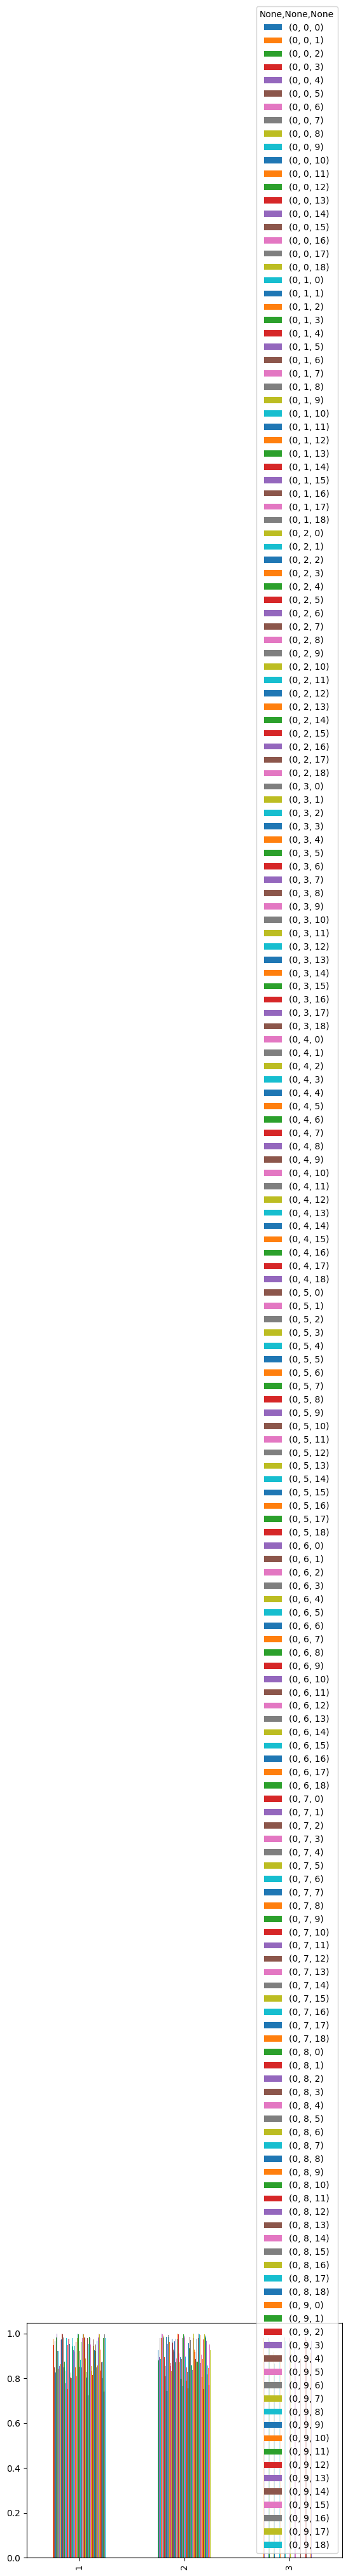

In [ ]:
f1_validations_df.unstack().unstack().plot.bar()